In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
#import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

comment = "Investigation into shape of ensemble of semi-variograms."
nb_name = "nb_seqsim_core_sh30_sv_all"

# Core

In [2]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)


In [3]:
core.generate_map(target_var_factor = 1)

In [4]:
g_core_ens = np.genfromtxt("lithosphere_prior/grids/shcoeff_Dynamo/gnm_midpath.dat").T*10**9

In [5]:
core.ensemble_B(g_core_ens, nmax = shc_g, r_at = core.r_cmb, grid_type = "glq")
m_core_ens = core.B_ensemble[:,0,:].copy()[:,200:]

var_core_ens = np.var(m_core_ens,axis=0)

idx_close_to_var = np.argwhere(np.logical_and(var_core_ens>0.9970*np.mean(var_core_ens), var_core_ens<1.0030*np.mean(var_core_ens)))

In [6]:
m_core_ens.shape

(1891, 487)

In [7]:
core.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 200,
             zero_nugget = True, hit_target_var = True)

keep_sv_curve = core.sv_curve.copy()
keep_lags_sv_curve = core.lags_sv_curve.copy()

C_e_const = 2.0

set_model = {"a": 1700, "C0": 0.0, "C1": core.target_var, "C2": None, "C3": None}

core.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 200,
             zero_nugget = True, hit_target_var = True, set_model = set_model)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 200.0 km
Number of lags: 54
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 200.0 km
Number of lags: 54
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


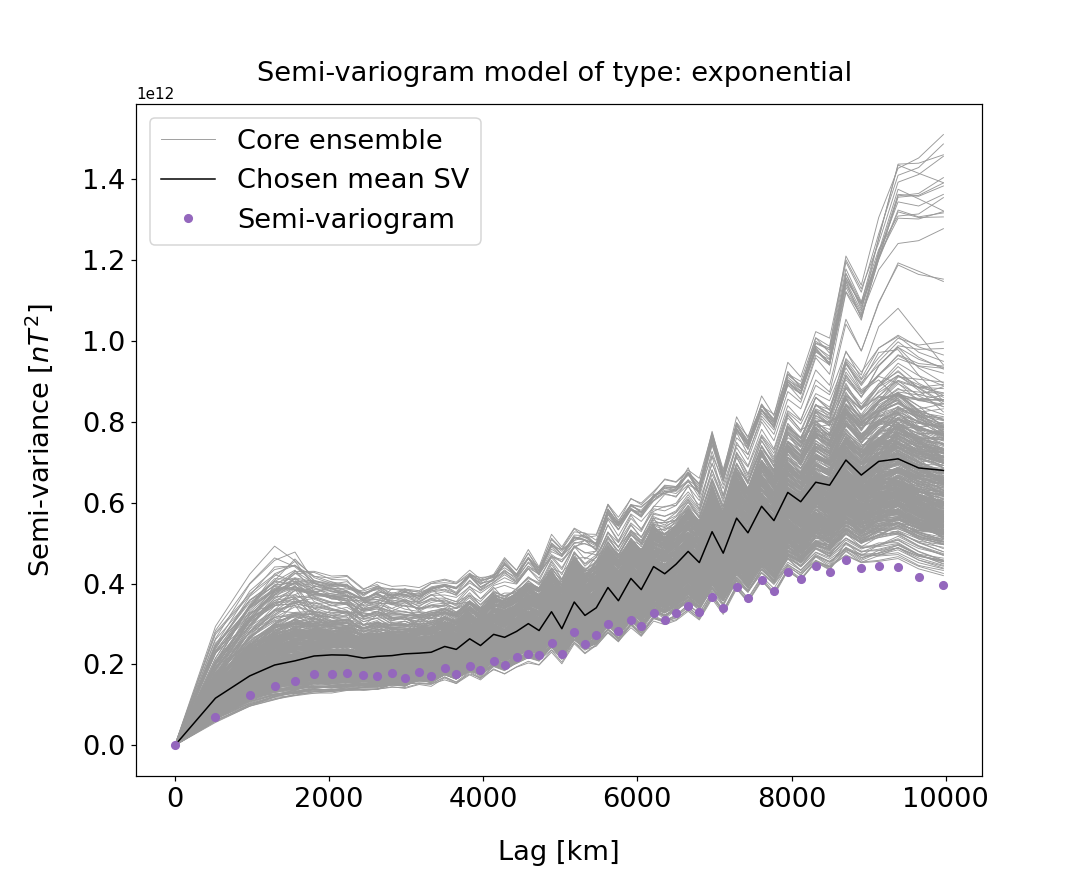

In [8]:
#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 

# Ensemble
for i in np.arange(0,m_core_ens.shape[1]):
    core.sv_m_DSS(m_core_ens.shape[0], 1, m_core_ens[:,[i]], core.sort_d, core.n_lags, core.max_cloud)
    if i == 0:
        plt.plot(core.lags, core.pics_m_DSS[:,0], color = (0.6,0.6,0.6), label='Core ensemble', linewidth = 0.6,zorder=0)
    elif i == idx_close_to_var[-1]:
        plt.plot(core.lags, core.pics_m_DSS[:,0], color = "black", label='Chosen mean SV', linewidth = 1.0,zorder=0.1)
    else:
        plt.plot(core.lags, core.pics_m_DSS[:,0], color = (0.6,0.6,0.6), linewidth = 0.6,zorder=0) 

plt.plot(core.lags,core.pics,'o', markersize=5,color = 'C4',label='Semi-variogram')
#plt.plot(core.lags_sv_curve,core.sv_curve,color='C1', linewidth = 1,label='Defined model')
#plt.plot(keep_lags_sv_curve,keep_sv_curve,"--",color='C0',linewidth = 1,label='Fitted model')

#plt.plot(core.lags_sv_curve,np.ones(core.lags_sv_curve.shape)*core.target_var,linewidth = 1,
#         color="C2", linestyle="dashed", label="Training image variance")


#core.sv_m_DSS(len(core.data), 1, core.data.reshape(-1,1), core.sort_d, core.n_lags, core.max_cloud)
#plt.plot(core.lags, core.pics_m_DSS, color = "black", label='Re-data', linewidth = 1.0)

plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % core.model_names[core.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

In [11]:
P = pyshtools.legendre.PlmSchmidt(20,0)

In [12]:
P

array([ 1.        ,  0.        ,  1.        , -0.5       ,  0.        ,
        0.8660254 , -0.        , -0.61237244,  0.        ,  0.79056942,
        0.375     , -0.        , -0.55901699,  0.        ,  0.73950997,
        0.        ,  0.48412292, -0.        , -0.52291252,  0.        ,
        0.70156076, -0.3125    ,  0.        ,  0.45285552, -0.        ,
       -0.49607837,  0.        ,  0.67169329, -0.        , -0.41339864,
        0.        ,  0.42961647, -0.        , -0.47495888,  0.        ,
        0.64725985,  0.2734375 , -0.        , -0.39218439,  0.        ,
        0.41132646, -0.        , -0.45768183,  0.        ,  0.62670665,
        0.        ,  0.3668549 , -0.        , -0.37548796,  0.        ,
        0.39636409, -0.        , -0.44314853,  0.        ,  0.60904939,
       -0.24609375,  0.        ,  0.35123683, -0.        , -0.36182926,
        0.        ,  0.38377788, -0.        , -0.43066296,  0.        ,
        0.59362792, -0.        , -0.33321251,  0.        ,  0.33

In [15]:
g_core_ens[:,0]

array([-4.53740949e+04, -3.36479265e+03, -2.10686571e+03, -3.50594414e+03,
        1.88832294e+03, -1.86237915e+03,  4.13940027e+02, -2.98238423e+02,
        1.54629598e+03, -2.08222493e+03, -9.93841645e+02, -2.16375108e+02,
        4.86783282e+02, -7.54874814e+02, -1.95067038e+01,  9.25053490e+01,
        1.77215931e+02, -7.99367599e+01, -2.79274583e+02, -8.68761314e+01,
       -3.34947007e+02,  6.69133617e+01,  7.09944797e+02, -1.28987082e+02,
        2.68761046e+02,  7.77961290e+01, -2.66536382e+02, -3.00137952e+02,
        2.07289586e+02, -1.64128507e+02, -3.12189006e+01, -2.30851813e+02,
        2.49398209e+02, -1.44047704e+02, -3.08971566e+02,  9.69064069e+00,
        4.19517043e+01,  3.25551826e+01, -7.37771036e+01, -7.78652483e+01,
       -5.14657616e+01,  1.90110950e+01, -2.56356826e+01, -5.76997778e+01,
        3.30894125e+01,  7.90250002e+01,  3.47681882e+01, -6.12040160e+01,
        6.72075691e+01,  1.85977006e+01, -1.09480204e+00,  1.26050689e+01,
       -1.69127329e+01, -

In [34]:
def lowe_shspec(n,c,a,g):

    g_cut = g[:n*(2+n)] # Truncate g

    i = np.arange(1,n+1) # Degree array
    reps = (i*(2+i)-(i-1)*(1+i)) # Coefficients per degree
    ns = np.repeat(i,reps) # Repeat degrees for each corresponding coefficient

    const = (ns+1)*(a/c)**(2*ns+4) # Array of constants for each corresponding coefficient

    g_const_sq = const*np.power(g_cut,2) # Multiply constant with squared g

    rep_cs = np.cumsum(reps) # Cumsum to split array for each degree

    split = np.split(g_const_sq,rep_cs)[:-1] # Perform split

    R = np.array([sum(i) for i in split]) # Sum coefficients for each degree
    
    return R

In [249]:
a = core.a
c = core.a
n = 30

g_cut = g_core_ens[:,0][:n*(2+n)] # Truncate g

i = np.arange(1,n+1) # Degree array
reps = (i*(2+i)-(i-1)*(1+i)) # Coefficients per degree
ns = np.repeat(i,reps) # Repeat degrees for each corresponding coefficient

const = (ns+1)*(a/c)**(2*ns+4) # Array of constants for each corresponding coefficient

g_const_sq = const*np.power(g_cut,2) # Multiply constant with squared g

rep_cs = np.cumsum(reps) # Cumsum to split array for each degree

split = np.split(g_const_sq,rep_cs)[:-1] # Perform split

split_sum = np.array([sum(i) for i in split]) # Sum coefficients for each degree

In [254]:
reps

array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61])

In [250]:
ens_cilm_compare = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,), g_cut))))

p_spec_compare = pyshtools.gravmag.mag_spectrum(ens_cilm_compare, a, c, degrees = np.arange(1,np.shape(ens_cilm_compare)[1]))

<IPython.core.display.Javascript object>


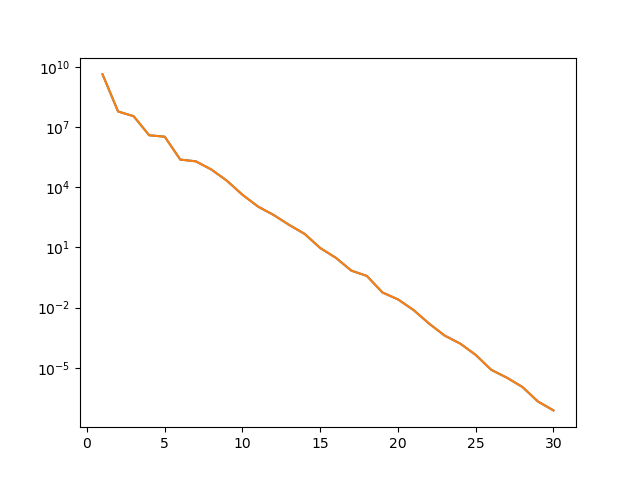

In [252]:
plt.figure()
plt.semilogy(np.arange(1,n+1),split_sum)
plt.semilogy(np.arange(1,n+1),p_spec_compare)
plt.show()

In [98]:
n = 1
g = g_core_ens[:,0]

i_N = n*(2+n)-(n-1)*(1+n)
i_end = (n+1)*(3+n)-n*(2+n)

print(i_N)
print(i_end)

g[:i_N]

3
5


array([-45374.0949 ,  -3364.79265,  -2106.86571])

In [36]:
R = []

for i in np.arange(1,20+1):
    R.append(lowe_shspec(i,core.a,core.a,g_core_ens[:,0]))

<IPython.core.display.Javascript object>


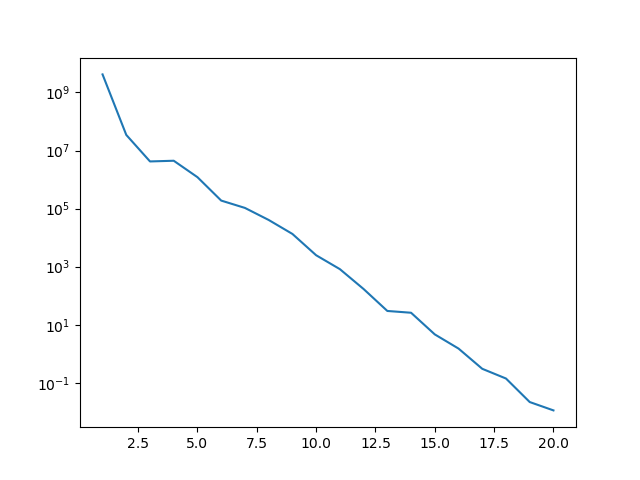

In [37]:
plt.figure()
plt.semilogy(np.arange(1,21),R)
plt.show()

In [19]:
print(core)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               Investigation into shape of ensemble of semi-variograms.
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  30
N_SH_secondary:        None
sim_type:              core
grid_zero:             (31,), Max/Min: 1.00 / -1.00
grid_w_shtools:        (31,), Max/Min: 0.10 / 0.01
grid_shape:            (2,), Max/Min: 61.00 / 31.00
grid_w:                (1891,), Max/Min: 0.10 / 0.01
grid_radial:           (1891,), Max/Min: 3480.00 / 3480.00
grid_theta:            (1891,), Max/Min: 175.63 / 4.37
grid_phi:              (1891,), Max/Min: 354.10 / 0.00
grid_N:                1891
grid_nmax:             30
r_grid:                3480.0
grid:                  (1891, 2)
sph_d:                 (1891, 1891)
lon:                